In [ ]:
!pip install tensorflow==1.15

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Flatten
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dropout, SimpleRNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Loading files
dataset1 = pd.read_csv("/content/sample_data/Emotion_final.csv")
dataset2 = pd.read_csv("/content/sample_data/text_emotion.csv")

In [ ]:
print(dataset1.shape, dataset2.shape)

(21459, 2) (40000, 4)


In [ ]:
dataset2 = dataset2.drop(columns=["tweet_id", "author"])
dataset2 = dataset2[['content', 'sentiment']]
dataset2 = dataset2.rename(columns={"content" : "Text", "sentiment": "Emotion"})

In [ ]:
# Merging datasets

final_dataset = dataset1.append(dataset2, ignore_index=True)
print(final_dataset.shape)

(61459, 2)


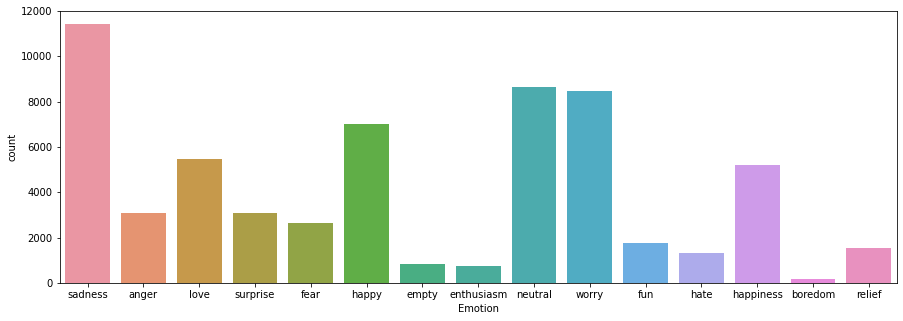

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(x='Emotion', data=final_dataset)
plt.show()

In [ ]:
# Preprocessing
lemmatizer = WordNetLemmatizer()

In [ ]:
def cleanSentence(sentence):
    sentence = re.sub(r"[?.,!><{}()%]+", ' ', sentence)
    sentence = re.sub(r"^@[a-zA-Z0-9]+", ' ', sentence)
    sentence = re.sub(r"_", ' ', sentence)
    sentence = re.sub(r"https?://[A-Za-z0-9./]+", ' ', sentence)
    sentence = sentence.strip()
    sentence = sentence.lower()
    return sentence


In [ ]:
def preprocess(sentence):
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can\'t", "cannot", sentence)
    sentence = re.sub(r"\'m", "am", sentence)
    sentence = re.sub(r"\'s", "is", sentence)
    sentence = re.sub(r"\'re", "are", sentence)
    sentence = re.sub(r"n\'t", "not", sentence)
    sentence = re.sub(r"\'t", "not", sentence)
    sentence = re.sub(r"\'ve", "have", sentence)
    sentence = re.sub(r"\'d", "would", sentence)
    sentence = re.sub(r"\'ll", "will", sentence)
    words = word_tokenize(sentence)
    words_clean = [word for word in words if word not in stopwords.words('english')]
    return words_clean

def lemmatizeAndPOStagging(tokens):
    words_pos_dict = pos_tag(tokens)
    tokens_final = []
    for word, tag in words_pos_dict:
        word_tag = tag[0].lower()
        if word_tag in ['a', 'r', 'v', 'n']:
            tokens_final.append(lemmatizer.lemmatize(word, word_tag))
        else:
            tokens_final.append(word)
    return tokens_final

def preprocessingWrapper(sentence):
    sentence = cleanSentence(sentence)
    tokens = preprocess(sentence)
    tokens = lemmatizeAndPOStagging(tokens)
    return tokens

In [ ]:
 nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

In [ ]:
final_dataset['tokens'] = final_dataset['Text'].apply(lambda sent : preprocessingWrapper(sent))

In [ ]:
final_dataset

,Text,Emotion,tokens
0,i didnt feel humiliated,sadness,"[didnt, feel, humiliate]"
1,i can go from feeling so hopeless to so damned...,sadness,"[go, feeling, hopeless, damn, hopeful, around,..."
2,im grabbing a minute to post i feel greedy wrong,anger,"[im, grab, minute, post, feel, greedy, wrong]"
3,i am ever feeling nostalgic about the fireplac...,love,"[ever, feel, nostalgic, fireplace, know, still..."
4,i am feeling grouchy,anger,"[feel, grouchy]"
...,...,...,...
61454,@JohnLloydTaylor,neutral,[]
61455,Happy Mothers Day All my love,love,"[happy, mother, day, love]"
61456,Happy Mother's Day to all the mommies out ther...,love,"[happy, motheris, day, mommy, woman, man, long..."
61457,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,happiness,"[wassup, beautiful, follow, peep, new, hit, si..."


In [ ]:
le = LabelEncoder()
final_dataset['Emotion'] = le.fit_transform(final_dataset['Emotion'])

In [ ]:
## Training and Testing
X = final_dataset['tokens']
y = final_dataset['Emotion']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
## Converting the textual data into numerical sequences and label encoding
## output labels
y_train = to_categorical(y_train.values)
y_test = to_categorical(y_test.values)

In [ ]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X)

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
len(X_train)

46094

In [ ]:
len(X_test)

15365

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=maxlen)


In [ ]:
## Use Glove embeddings to determine semantic relationships between related words
 
from numpy import asarray, array, zeros

embeddings_dict = dict()
glove_file = open(r"/content/sample_data/glove.6B.100d.txt", encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dict[word] = vector_dimensions
glove_file.close()

embedding_matrix = np.zeros((vocab_size, maxlen))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
y_train.shape

(46094, 15)

In [ ]:
!pip install -U numpy==1.18.5

     |████████████████████████████████| 20.1 MB 1.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.16.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
tables 3.7.0 requires numpy>=1.19.0, but you have numpy 1.18.5 which is incompatible.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have tensorflow 1.15.0 which is incompatible.
jaxlib 0.3.2+cuda11.cudnn805 requires numpy>=1.19, but you have numpy 1.18.5 which is incompatible.
jax 0.3.4 requires numpy>=1.19, but you have numpy 1.18.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you hav

In [ ]:
## Model development : RNN, LSTM, BiLSTM
model_rnn = Sequential([
    Embedding(input_dim = vocab_size,
              output_dim = maxlen,
              input_length = X_train.shape[1],
              weights = [embedding_matrix], trainable = False),
    Dropout(0.2),
    SimpleRNN(100),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dense(15, activation='softmax')])

model_rnn.summary()
model_rnn.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          4130600   
                                                                 
 dropout_4 (Dropout)         (None, 100, 100)          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               20100     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 15)                1515      
                                                                 
Total params: 4,162,315
Trainable params: 31,715
Non-t

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = vocab_size,
                         output_dim = maxlen,
                         input_length = X_train.shape[1],
                         weights=[embedding_matrix], trainable = False))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(100, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(100, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(100, return_sequences=False))
model_lstm.add(Dense(100, activation='relu'))
model_lstm.add(Dense(15, activation='softmax'))

model_lstm.summary()
model_lstm.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          4130600   
                                                                 
 dropout_6 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_4 (LSTM)               (None, 100, 100)          80400     
                                                                 
 dropout_7 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_5 (LSTM)               (None, 100, 100)          80400     
                                                                 
 dropout_8 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_6 (LSTM)               (None, 100)              

In [ ]:
model_bilstm = Sequential()
model_bilstm.add(Embedding(input_dim = vocab_size,
                         output_dim = maxlen,
                         input_length = X_train.shape[1],
                         weights=[embedding_matrix], trainable = False))
model_bilstm.add(Dropout(0.2))
model_bilstm.add(Bidirectional(LSTM(150, return_sequences = True)))
model_bilstm.add(Dropout(0.2))
model_bilstm.add(Bidirectional(LSTM(150, return_sequences = True)))
model_bilstm.add(Dropout(0.2))
model_bilstm.add(Bidirectional(LSTM(150, return_sequences = False)))
model_bilstm.add(Dense(15, activation='softmax'))

model_bilstm.summary()
model_bilstm.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          4130600   
                                                                 
 dropout_9 (Dropout)         (None, 100, 100)          0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 100, 300)         301200    
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 100, 300)          0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 100, 300)         541200    
 nal)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 100, 300)         

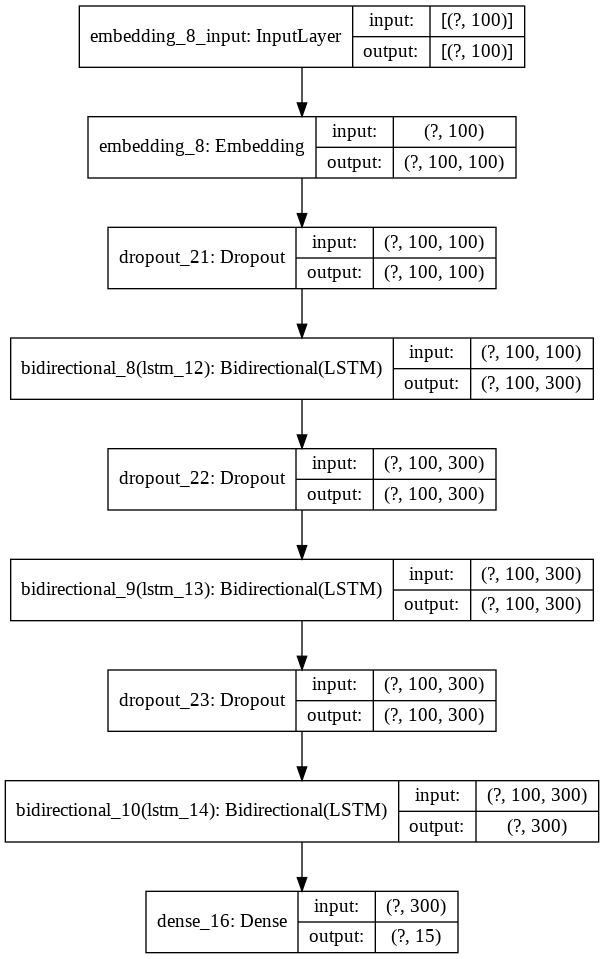

In [ ]:
tf.keras.utils.plot_model(model_bilstm, to_file="bilstm_model.png", show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor= 'val_loss', mode='min', verbose=1, patience=5)
# mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [ ]:
# Train RNN model
history_rnn = model_rnn.fit(X_train, y_train, epochs=25, batch_size=128, validation_split=0.2, callbacks = [es])

Train on 36875 samples, validate on 9219 samples
Epoch 1/25
36875/36875 [==============================] - 24s 658us/sample - loss: 2.3994 - acc: 0.1793 - val_loss: 2.3634 - val_acc: 0.1891
Epoch 2/25
36875/36875 [==============================] - 24s 641us/sample - loss: 2.3839 - acc: 0.1851 - val_loss: 2.3600 - val_acc: 0.1891
Epoch 3/25
36875/36875 [==============================] - 23s 616us/sample - loss: 2.3833 - acc: 0.1872 - val_loss: 2.3623 - val_acc: 0.1891
Epoch 4/25
36875/36875 [==============================] - 22s 609us/sample - loss: 2.3812 - acc: 0.1873 - val_loss: 2.3615 - val_acc: 0.1891
Epoch 5/25
36875/36875 [==============================] - 23s 610us/sample - loss: 2.3811 - acc: 0.1871 - val_loss: 2.3602 - val_acc: 0.1891
Epoch 6/25
36875/36875 [==============================] - 23s 611us/sample - loss: 2.3798 - acc: 0.1871 - val_loss: 2.3608 - val_acc: 0.1891
Epoch 7/25
36875/36875 [==============================] - 23s 632us/sample - loss: 2.3802 - acc: 0.1870 -

In [ ]:
# Train lstm model
history_lstm = model_lstm.fit(X_train, y_train, epochs=25, batch_size=128, validation_split=0.2, callbacks = [es])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 36875 samples, validate on 9219 samples
Epoch 1/25
36875/36875 [==============================] - 280s 8ms/sample - loss: 2.3963 - acc: 0.1859 - val_loss: 2.3685 - val_acc: 0.1891
Epoch 2/25
36875/36875 [==============================] - 277s 8ms/sample - loss: 2.3809 - acc: 0.1871 - val_loss: 2.3580 - val_acc: 0.1891
Epoch 3/25
36875/36875 [==============================] - 277s 8ms/sample - loss: 2.3800 - acc: 0.1871 - val_loss: 2.3606 - val_acc: 0.1891
Epoch 4/25
36875/36875 [==============================] - 277s 8ms/sample - loss: 2.3794 - acc: 0.1871 - val_loss: 2.3606 - val_acc: 0.1891
Epoch 5/25
36875/36875 [==============================] - 277s 8ms/sample - loss: 2.3793 - acc: 0.1871 - val_loss: 2.3601 - val_acc: 0.1891
Epoch 6/25
36875/36875 [==============================] - 282s 8ms/sample - loss: 2.3785 - acc: 0.1871 - val_loss: 2.3613 - val_acc: 0.1891
Epoch 7/25
36875/

In [ ]:
# Train Bilstm model
history_bilstm = model_bilstm.fit(X_train, y_train, epochs=25, batch_size=128, validation_split=0.2, callbacks = [es])

Train on 36875 samples, validate on 9219 samples
Epoch 1/25
36875/36875 [==============================] - 1634s 44ms/sample - loss: 1.9367 - acc: 0.3325 - val_loss: 1.7704 - val_acc: 0.4008
Epoch 2/25
36875/36875 [==============================] - 1624s 44ms/sample - loss: 1.7271 - acc: 0.4138 - val_loss: 1.6345 - val_acc: 0.4478
Epoch 3/25
36875/36875 [==============================] - 1614s 44ms/sample - loss: 1.6159 - acc: 0.4545 - val_loss: 1.5325 - val_acc: 0.4836
Epoch 4/25
36875/36875 [==============================] - 1649s 45ms/sample - loss: 1.5402 - acc: 0.4805 - val_loss: 1.4760 - val_acc: 0.5030
Epoch 5/25
36875/36875 [==============================] - 1639s 44ms/sample - loss: 1.4848 - acc: 0.4982 - val_loss: 1.4483 - val_acc: 0.5120
Epoch 6/25
36875/36875 [==============================] - 1612s 44ms/sample - loss: 1.4358 - acc: 0.5134 - val_loss: 1.4369 - val_acc: 0.5158
Epoch 7/25
36875/36875 [==============================] - 1629s 44ms/sample - loss: 1.3950 - acc: 0

In [ ]:
model_bilstm.save("bilstm_model")

In [ ]:
## Testing 
y_pred_rnn = np.argmax(model_rnn.predict(X_test), axis=1)
y_true_rnn = np.argmax(y_test, axis=1)
print("RNN Predicted: ", metrics.classification_report(y_true_rnn, y_pred_rnn))

RNN Predicted:                precision    recall  f1-score   support

           0       0.00      0.00      0.00       772
           1       0.00      0.00      0.00        42
           2       0.00      0.00      0.00       210
           3       0.00      0.00      0.00       206
           4       0.00      0.00      0.00       662
           5       0.00      0.00      0.00       450
           6       0.00      0.00      0.00      1322
           7       0.00      0.00      0.00      1773
           8       0.00      0.00      0.00       343
           9       0.00      0.00      0.00      1394
          10       0.15      0.13      0.14      2091
          11       0.00      0.00      0.00       415
          12       0.19      0.88      0.31      2786
          13       0.00      0.00      0.00       765
          14       0.22      0.04      0.06      2134

    accuracy                           0.18     15365
   macro avg       0.04      0.07      0.03     15365
weighted a

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_pred_lstm = np.argmax(model_lstm.predict(X_test), axis=1)
y_true_lstm = np.argmax(y_test, axis=1)
print("LSTM Predicted: ", metrics.classification_report(y_true_lstm, y_pred_lstm))

LSTM Predicted:                precision    recall  f1-score   support

           0       0.00      0.00      0.00       772
           1       0.00      0.00      0.00        42
           2       0.00      0.00      0.00       210
           3       0.00      0.00      0.00       206
           4       0.00      0.00      0.00       662
           5       0.00      0.00      0.00       450
           6       0.00      0.00      0.00      1322
           7       0.00      0.00      0.00      1773
           8       0.00      0.00      0.00       343
           9       0.00      0.00      0.00      1394
          10       0.00      0.00      0.00      2091
          11       0.00      0.00      0.00       415
          12       0.18      1.00      0.31      2786
          13       0.00      0.00      0.00       765
          14       0.00      0.00      0.00      2134

    accuracy                           0.18     15365
   macro avg       0.01      0.07      0.02     15365
weighted 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_pred_bilstm = np.argmax(model_bilstm.predict(X_test), axis=1)
y_true_bilstm = np.argmax(y_test, axis=1)
print("Bi-LSTM Predicted: ", metrics.classification_report(y_true_bilstm, y_pred_bilstm))

Bi-LSTM Predicted:                precision    recall  f1-score   support

           0       0.90      0.74      0.81       772
           1       0.00      0.00      0.00        42
           2       0.00      0.00      0.00       210
           3       0.00      0.00      0.00       206
           4       0.86      0.82      0.84       662
           5       0.09      0.05      0.06       450
           6       0.29      0.44      0.35      1322
           7       0.91      0.88      0.89      1773
           8       0.34      0.25      0.29       343
           9       0.56      0.52      0.54      1394
          10       0.34      0.51      0.41      2091
          11       0.14      0.03      0.04       415
          12       0.63      0.65      0.64      2786
          13       0.49      0.24      0.32       765
          14       0.34      0.36      0.35      2134

    accuracy                           0.51     15365
   macro avg       0.39      0.36      0.37     15365
weight

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_rnn.metrics_names

['loss', 'acc']

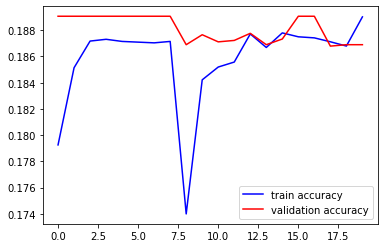

In [ ]:
## Plotting
plt.plot(history_rnn.history["acc"],c='b',label='train accuracy')
plt.plot(history_rnn.history["val_acc"],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

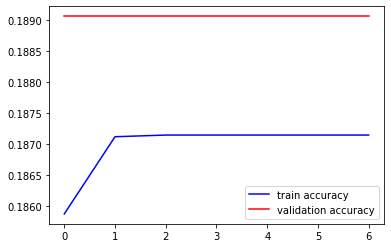

In [ ]:
plt.plot(history_lstm.history["acc"],c='b',label='train accuracy')
plt.plot(history_lstm.history["val_acc"],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

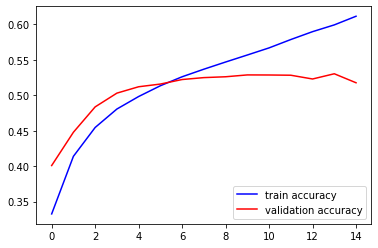

In [ ]:
plt.plot(history_bilstm.history["acc"],c='b',label='train accuracy')
plt.plot(history_bilstm.history["val_acc"],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()